<p style="font-family: Arial; font-size:4.15em; color:navy; font-style:bold"><br>
Intelligent Data Analysis</p><br>

## Part III Decision Trees  
Pavol Grofčík  
Dennis Sobolev

In [260]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
import math
import json as js
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import re
import statsmodels.api as sm
from sklearn import neighbors
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import Normalizer,LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#from graphviz import Source    
from IPython.display import SVG
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold

#Importing our preprocessing scripts - Preprocesing_Scripts.py
import Preprocesing_Scripts as ps

#Filter out warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

<p style="font-family: Arial; font-size:2.95em; color:gold; font-style:bold"><br>
Content</p><br>

## Following sections

In this NB we provide our finish goal - **prediction of health state** of patients based on hormone values and other factors.
The prediction is made by **Decision Trees** and at the end of our NB we conclude different approaches using different techniques dealing with missing values.

**The following sections include:**

* **I. Loading and preprocessing train & valid datasets**  
* **II. Manual Prediction**  
* **III. Decision Tree model**  
* **IV. Comparison between manual model and Decision Tree model**  
* **V. Application on the test dataset**
* **Conclusion**

# I. Loading and preprocessing train/valid datasets

In [2]:
#In this phase we compare two techniques - median/mean method with dealing with missing values
#Lists with train & valid datasets preprocessed with the chosen technique
Medians = []
Means = []

In [3]:
#Loading train sample
df_personal = pd.read_csv("Datasets/personal_train.csv", index_col=0)
df_other = pd.read_csv("Datasets/other_train.csv", index_col=0)
df_personal.head()

,name,address,age,sex,date_of_birth
0,Terry Terry,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",68.0,M,1949-11-16
1,Edith Boudreaux,"PSC 4657, Box 5446\nAPO AP 58412",75.0,F,1943-08-10
2,Stephen Lalk,Unit 9759 Box 9470\nDPO AP 45549,67.0,M,1951-05-28
3,Abraham Bruce,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",34.0,?,1984-02-13
4,Janet Washington,"995 Frank Stravenue\nSouth Matthewport, TX 81402",65.0,F,1953/06/24


In [225]:
#The same process applied to valid sample
df_val_personal = pd.read_csv("Datasets/personal_valid.csv", index_col=0)
df_val_other = pd.read_csv("Datasets/other_valid.csv", index_col=0)


## Merging and preprocessing datasets

In [5]:
#In this section we need to preprocess train & valid datasets twice - using mean and median method for both part
df_merged = pd.merge(df_personal,df_other, on=["name", "address"], how="inner", sort = True, copy = True)

In [6]:
df_merged_valid = pd.merge(df_val_personal, df_val_other, on=["name", "address"], how = "inner", sort = True, copy = True)

In [7]:
df_merged[df_merged["name"] == "Flora Jackson"].head()

,name,address,age,sex,date_of_birth,query hyperthyroid,FTI measured,education,lithium,TT4,...,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
754,Flora Jackson,"4798 Carter Turnpike\nJosemouth, WV 19340",39.0,F,1979-02-26 00 00 00,t,t,HS-grad,f,84.0,...,NaN,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,9.0,Adm-clerical,f,?,White,85
755,Flora Jackson,"4798 Carter Turnpike\nJosemouth, WV 19340",39.0,F,1979-02-26 00 00 00,t,t,HS-grad,f,84.0,...,f,"{'query hypothyroid':'f','T4U measured':'t','p...",NaN,other,9.0,Adm-clerical,NaN,?,White,85


In [8]:
#We create common mask to identify duplicates
mask = df_merged.duplicated(subset=["name", "address"])

In [9]:
#Here we select only the rows that are duplicated
duplicates = df_merged[mask == True]

In [10]:
#Here we merge our datasets into one separate for median/mean method
ps.fill_from_duplicates(df=df_merged, duplicates=duplicates, indexes=duplicates.index)
ps.fill_from_duplicates(df=df_merged_valid, duplicates=duplicates, indexes=duplicates.index)

Done


In [11]:
df_merged[df_merged["name"] == "Flora Jackson"]

,name,address,age,sex,date_of_birth,query hyperthyroid,FTI measured,education,lithium,TT4,...,hypopituitary,medical_info,on antithyroid medication,referral source,education-num,occupation,TBG measured,TBG,race,FTI
741,Flora Jackson,"4798 Carter Turnpike\nJosemouth, WV 19340",39.0,F,1979-02-26 00 00 00,t,t,HS-grad,f,84.0,...,f,"{'query hypothyroid':'f','T4U measured':'t','p...",f,other,9.0,Adm-clerical,f,?,White,85


In [12]:
#Formatting the date
df_merged["date_of_birth"] = df_merged["date_of_birth"].apply(lambda x: ps.format_date(date=x))
df_merged_valid["date_of_birth"] = df_merged_valid["date_of_birth"].apply(lambda x: ps.format_date(date=x))

In [13]:
#Parsing JSON medical info
df_merged = ps.add_columns(data=df_merged, json_col = "medical_info")
df_merged_valid = ps.add_columns(data = df_merged_valid, json_col = "medical_info")

In [14]:
#Normalizing categorical columns
ps.normalize_columns_booleans(data = df_merged, df_new= df_merged)
ps.normalize_columns_booleans(data = df_merged_valid, df_new= df_merged_valid)

Normalized query hyperthyroid
Normalized FTI measured
Normalized lithium
Normalized tumor
Normalized sick
Normalized TT4 measured
Normalized goitre
Normalized hypopituitary
Normalized on antithyroid medication
Normalized TBG measured
Normalized query hypothyroid
Normalized T4U measured
Normalized pregnant
Normalized thyroid surgery
Normalized TSH measured
Normalized query on thyroxine
Normalized I131 treatment
Normalized on thyroxine
Normalized T3 measured
Normalized psych
Normalized query hyperthyroid
Normalized FTI measured
Normalized lithium
Normalized tumor
Normalized sick
Normalized TT4 measured
Normalized goitre
Normalized hypopituitary
Normalized on antithyroid medication
Normalized TBG measured
Normalized query hypothyroid
Normalized T4U measured
Normalized pregnant
Normalized thyroid surgery
Normalized TSH measured
Normalized query on thyroxine
Normalized I131 treatment
Normalized on thyroxine
Normalized T3 measured
Normalized psych


In [15]:
#Special kind of normalization
#Stripping the class column for both - train and valid dataset
df_merged["class"] = df_merged["class"].str.replace("_","")
df_merged["class"] = df_merged["class"].str.replace("|","")
df_merged[["class", "class_num"]] = df_merged["class"].str.split(".",expand = True)

df_merged_valid["class"] = df_merged_valid["class"].str.replace("_", "")
df_merged_valid["class"] = df_merged_valid["class"].str.replace("|", "")
df_merged_valid[["class", "class_num"]] = df_merged_valid["class"].str.split(".", expand = True)

In [16]:
df_merged["class"].head()

0                     negative
1    increased binding protein
2                     negative
3                     negative
4                     negative
Name: class, dtype: object

In [17]:
df_merged[df_merged.columns[15:]].head()

,T3,fnlwgt,hours-per-week,relationship,sick,workclass,TT4 measured,class,marital-status,goitre,...,T4U measured,pregnant,thyroid surgery,TSH measured,query on thyroxine,I131 treatment,on thyroxine,T3 measured,psych,class_num
0,2.0,240810.0,45.0,Husband,f,private,t,negative,Married-civ-spouse,f,...,t,f,f,t,f,f,f,t,f,511
1,3.0,55743.0,45.0,Wife,f,Private,t,increased binding protein,Married-civ-spouse,f,...,t,f,f,t,f,f,f,t,f,1799
2,2.0,193868.0,50.0,Not-in-family,f,Self-emp-inc,t,negative,Never-married,f,...,t,f,f,t,f,f,f,t,f,2741
3,1.6,119069.0,40.0,Husband,f,Self-emp-not-inc,t,negative,Married-civ-spouse,f,...,t,f,f,t,f,f,f,t,f,542
4,1.8,195189.0,40.0,Unmarried,f,Private,t,negative,Divorced,f,...,t,f,f,t,f,f,f,t,f,72


# Creating mean and median datasets

In [18]:
df_mean=df_merged.copy()
df_med=df_merged.copy()

df_mean_valid=df_merged_valid.copy()
df_med_valid=df_merged_valid.copy()

In [19]:
#Here we fill missing values by chosen technique for columns we will use in next phase
Filled_cols = ["TT4", "T4U", "TSH", "T3"]

#Iterating over columns and filling it 
for column in Filled_cols:

    ps.fill_numeric_miss_values(data=df_mean, column =column, method="mean")
    ps.fill_numeric_miss_values(data=df_mean_valid, column = column, method="mean")
    ps.fill_numeric_miss_values(data=df_med, column = column, method= "med")
    ps.fill_numeric_miss_values(data=df_med_valid, column = column, method= "med")


MEAN  Value is: 109.32809956917185
Filling missing values by MEAN done!
MEAN  Value is: 105.93978723404254
Filling missing values by MEAN done!
MED  Value is: 109.32809956917185
Filling missing values by MED done!
MED  Value is: 105.93978723404254
Filling missing values by MED done!
MEAN  Value is: 0.9961508491508485
Filling missing values by MEAN done!
MEAN  Value is: 0.9874944320712697
Filling missing values by MEAN done!
MED  Value is: 0.9961508491508485
Filling missing values by MED done!
MED  Value is: 0.9874944320712697
Filling missing values by MED done!
MEAN  Value is: 4.501820448877802
Filling missing values by MEAN done!
MEAN  Value is: 6.209628603104214
Filling missing values by MEAN done!
MED  Value is: 4.501820448877802
Filling missing values by MED done!
MED  Value is: 6.209628603104214
Filling missing values by MED done!
MEAN  Value is: 2.024237288135594
Filling missing values by MEAN done!
MEAN  Value is: 1.9864356435643564
Filling missing values by MEAN done!
MED  Valu

In [20]:
#Function calculates current age from date of birth
def calculate_age(born):
    today = dt.datetime.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [21]:
#Script for parsing date to appropriate value
def parse_date(df, date_col):
    date = df[date_col].copy()
    
    years = 100
    days_per_year = 365.24
    
    for i in range(0,len(date)):
        date[i] = str(date[i])
        if(len(date[i].split("-")[0]) > 2):
            date[i] = date[i][2:]
            if(len(date[i]) > 2):
                date[i] = dt.datetime.strptime(date[i], "%y-%m-%d")
                date[i] = date[i] - dt.timedelta(days = (years*days_per_year))
                
        else:
            if(len(date[i]) > 2):
                date[i] = dt.datetime.strptime(date[i], "%y-%m-%d")
                date[i] = date[i] - dt.timedelta(days = (years*days_per_year))

        
        
    df[date_col] = date  

In [22]:
#Parsing dates
parse_date(df_mean, "date_of_birth")
parse_date(df_med, "date_of_birth")
#parse_date(df_med_valid, "date_of_birth")
#parse_date(df_mean_valid, "date_of_birth")

## One hot encoding

In [24]:
#Check what number for "class" represents which diagnosis
df_med[df_med['class']=='negative']['name'].head(1)

0    Aaron Johansen
Name: name, dtype: object

In [25]:
df_med[df_med['class']=='increased binding protein']['name'].head(1)

1    Abigail Martinez
Name: name, dtype: object

In [26]:
df_med[df_med['class']=='decreased binding protein']['name'].head(1)

483    Daniel Horner
Name: name, dtype: object

In [27]:
#Selecting columns that will be one-hot encoded
Labeled_colums = ["pregnant", "psych", "I131 treatment", "goitre", 
                 "tumor", "thyroid surgery", "class", "sex", "on thyroxine",
                 "query hyperthyroid", "query hypothyroid"]

a=pd.DataFrame()

#Label encoding for all columns
for col in Labeled_colums:
    lbl_encoder = LabelEncoder()    
    
    df_med[col] = df_med[col].apply(lambda x: str(x))
    df_med_valid[col] = df_med_valid[col].apply(lambda x: str(x))
    df_mean[col] = df_mean[col].apply(lambda x: str(x))
    df_mean_valid[col] = df_mean_valid[col].apply(lambda x: str(x))
    
    df_med[col + "_en"] = lbl_encoder.fit_transform(df_med[col])
    a[col+"_en"] = lbl_encoder.fit_transform(df_med[col])
    df_med_valid[col + "_en"] = lbl_encoder.fit_transform(df_med_valid[col])
    df_mean[col + "_en"] = lbl_encoder.fit_transform(df_mean[col])
    df_mean_valid[col + "_en"] = lbl_encoder.fit_transform(df_mean_valid[col])
    
    print(col + " encoded!")

pregnant encoded!
psych encoded!
I131 treatment encoded!
goitre encoded!
tumor encoded!
thyroid surgery encoded!
class encoded!
sex encoded!
on thyroxine encoded!
query hyperthyroid encoded!
query hypothyroid encoded!


In [28]:
#After column label encoding we

Labeled_colums = ["pregnant", "psych", "I131 treatment", "goitre", 
                 "tumor", "thyroid surgery", "sex", "on thyroxine",
                 "query hyperthyroid", "query hypothyroid"]

for col in Labeled_colums:
    ohe = OneHotEncoder()
    
    Xcol = ohe.fit_transform(df_mean[col].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(Xcol, columns = [str(col)+str(int(i)) for i in range(Xcol.shape[1])])
    pd.concat([df_mean, dfOneHot], axis=1)

In [29]:
#Check encoded values for "class" column
df_mean[df_mean['name']=='Aaron Johansen'][['class','class_en']]

,class,class_en
0,negative,2


In [30]:
df_mean[df_mean['name']=='Abigail Martinez'][['class','class_en']]

,class,class_en
1,increased binding protein,1


In [31]:
df_mean[df_mean['name']=='Daniel Horner'][['class','class_en']]

,class,class_en
483,decreased binding protein,0


### Here is the encoded data, so we can build a model 

In [32]:
df_mean.head()

,name,address,age,sex,date_of_birth,query hyperthyroid,FTI measured,education,lithium,TT4,...,psych_en,I131 treatment_en,goitre_en,tumor_en,thyroid surgery_en,class_en,sex_en,on thyroxine_en,query hyperthyroid_en,query hypothyroid_en
0,Aaron Johansen,"744 Sandoval Causeway\nEast Robertburgh, NC 69901",59.0,M,1959-08-06 00:00:00,f,t,Assoc-acdm,f,118.0,...,0,0,0,0,0,2,2,0,0,0
1,Abigail Martinez,"59351 Craig Courts\nGordonbury, WI 53797",18.0,F,1899-12-09 00:00:00,f,t,Bachelors,f,143.0,...,0,0,0,0,0,1,1,0,0,0
2,Abraham Bruce,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",34.0,?,1884-02-13 00:00:00,f,t,HS-grad,f,95.0,...,0,0,0,1,0,2,0,0,0,0
3,Abraham Hicks,"031 Wood Wall Apt. 152\nVictorburgh, CA 40253",29.0,M,1889-10-04 00:00:00,f,t,Bachelors,f,135.0,...,0,0,0,0,0,2,2,0,0,0
4,Ada Jeffries,"66827 Ortiz Radial\nWest Justin, IL 04779",70.0,F,1948-04-25 00:00:00,f,t,Some-college,f,122.0,...,0,0,0,0,0,2,1,0,0,0


# II. Manual Prediction

According to medical compendium for thyroid diagnostics, parameters we ultimately need are: TSH, TT4, T4U and T3 hormones. T3U could also be useful, but unfortunately, we don't have T3U measurements in our data.

Here are the rules for categorizing:
> 1. If **TSH <0.4**:  
>> Check the level of T3 and T4. If **T3 >2.8** _nanomole/liter_ OR/AND **TT4 >140** _nanomole/liter_ OR/AND **T4U >65** _nanomole/liter_, then the diagnosis is highly close to **hyperthyroidism**.  
> 2. If **TSH >4.0**:  
>> Check the level of T4. If **TT4 <60** _nanomole/liter_ OR/AND **T4U <20** _nanomole/liter_, then the diagnosis is highly close to **hypothyroidism**.  

Normal values for the hormones are:

> **TSH**: 0.4-4.0 nanomole/liter  
> **TT4**: 60-140 nanomole/liter  
> **T4U**: 20-65 nanomole/liter  
> **T3**: 0.9-2.8 nanomole/liter  

In order to avoid false positive predictions due to very strict bounds, it's possible to tolerate a 5-15% deviation for each parameter.

In [55]:
def manual_predict(dframe=None):
    decreased=[]
    increased=[]
    predicted=[]
    for index, row in dframe.iterrows():
        if row['TSH'] < 0.4:
            if row['TT4'] > 140 and row['T4U'] > 0.65 or row['T3'] > 2.8:
                #increased.append(index)
                predicted.append("increased binding protein")
            else:
                predicted.append("negative")
        elif row['TSH'] > 4:
            if row['TT4'] < 60 and row['T4U'] < 0.2 or row['T3'] < 0.9:
                #decreased.append(index)
                predicted.append("decreased binding protein")
            else:
                predicted.append("negative")
        else:
            predicted.append("negative")
    print(len(predicted),len(dframe))

    return predicted

### Counting Accuracy, Precision and Recall:

In [59]:
def apr_manual(dfr=None):
    dframe=None
    dframe=dfr
    true_positive=0
    true_negative=0
    false_positive=0
    false_negative=0
    accuracy=0
    precision=0
    recall=0
    for index, row in dframe.iterrows():
        if row['class']==row['class_predicted_manual']:
            if row['class']=="negative":
                true_negative+=1
            else:
                true_positive+=1
        else:
            if row['class']=="negative" and (row['class_predicted_manual']=="increased binding protein" 
                                             or row['class_predicted_manual']=="decreased binding protein"):
                false_positive+=1
            elif row['class_predicted_manual']=="negative" and (row['class']=="increased binding protein" 
                                             or row['class']=="decreased binding protein"):
                false_negative+=1
    
    accuracy = (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    
    print("Accuracy:",accuracy,"Precision:",precision,"Recall:",recall)

In [279]:
# APR metrics for dataframe, filled by median values
pred_manual=manual_predict(df_med)
df_med['class_predicted_manual']=pred_manual
apr_manual(df_med)

2237 2237
Accuracy: 0.8815377738042021 Precision: 0.14666666666666667 Recall: 0.3113207547169811


In [65]:
# APR metrics for dataframe, filled by mean values
pred_manual=manual_predict(df_mean)
df_mean['class_predicted_manual']=pred_manual
apr_manual(df_mean)

2237 2237
Accuracy: 0.8815377738042021 Precision: 0.14666666666666667 Recall: 0.3113207547169811


# III. Decision Tree model

Here we shall create a tree with an entropy as its criterion and use it on our data with **2 types of features**:
**full related categories** (e.g., both hormones and all necessary binary attributes), and **only hormones**, as in our manual clasifier.

This is done due to the fact, that not all **tumors, goitres etc.** are really related to thyroid disfunction, and so their usage in manual classifier shall create overcomplex model and will likely provide more false-positive predictions than it already has with fewer hyperparameters. But decision tree model learns flexibly, and more than that, is not bound to current medical standards for hormone values of healthy patients, as they are recalculated periodically and require direct changes in manual prediction model.


### Decision tree essential hyperparameters:


> **criterion** - a way to measure the quality of tree split. In sklearn implementation there are two criterias: Gini impurity and information gain rate. Gini impurity defines how often a randomly chosen element would be incorrectly randomly labeled. Information gain helps to choose the split with the purest daughter nodes (e.g., without need for further depth splitting).  

> **depth** - maximal depth of the tree. Sometimes it is better to define it manually and limit to lesser value, in order to avoid overfitting.  

> **max features** - a number of features to split a tree node further.  

> **min samples split/leaf** - minimal number of samples, which should be present in tree leaf, and minimal number of samples, that would be considered enough to split a node further.  

Other parameters for SKlearn tree algorithm implementation are also present, but are not needed for our particular case. To keep things as simple as possible and avoid model overcomplication, this particular decision tree will be measured based on "Entropy" criterion and different depth values. Other parameters will be ignored.



In [217]:
def tree_model(df_target, features, name, sd):
    classes=df_target['class'].unique()
    
    kf = KFold(n_splits=10, shuffle=True, random_state=sd)
    
    plot_acc=[]
    plot_pre=[]
    plot_rec=[]
    
    for depth in range(1,21):
        fold_count = 0
        acc=[]
        rec=[]
        pre=[]
        score=[['Accuracy', 'Precision', 'Recall']]
        
        for train, test in kf.split(df_target[features],df_target['class']):
        
            train_fold = df_target.iloc[train]
            test_fold = df_target.iloc[test]
            
            # Get training examples
            train_fold_input = train_fold[features].values
            train_fold_output = train_fold['class']
            
            # Fit tree
            tree = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
            tree.fit(train_fold_input, train_fold_output)
            
            # Check scores set
            pred = tree.predict(test_fold[features])
            acc.append(accuracy_score(test_fold['class'], pred))
            pre.append(precision_score(test_fold['class'], pred, average='weighted', labels=test_fold['class'].unique()))
            rec.append(recall_score(test_fold['class'], pred, average='weighted', labels=test_fold['class'].unique()))
            score.append([accuracy_score(test_fold['class'], pred),
                          precision_score(test_fold['class'], pred, average='weighted', labels=test_fold['class'].unique()),
                          recall_score(test_fold['class'], pred, average='weighted', labels=test_fold['class'].unique())])
            
            fold_count += 1
            
        plot_acc.append(np.average(acc))
        plot_pre.append(np.average(pre))
        plot_rec.append(np.average(rec))
    
    xx=[i for i in range(1,21)]  
    line1, = plt.plot(xx,plot_acc, "b", label="AVG accuracy",linestyle="-")
    line2, = plt.plot(xx,plot_pre, "g", label="AVG precision",linestyle="-.")
    line3, = plt.plot(xx,plot_rec, "r", label="AVG recall",linestyle=":",linewidth=4)
    
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    
    plt.ylabel("AVG metrics")
    plt.xlabel("Depth")
    plt.xticks(np.arange(min(xx), max(xx)+1, 1.0))
    plt.suptitle(name)
    plt.show()
    
    return tree
        

############ DF MEDIAN ############
Seed: 95


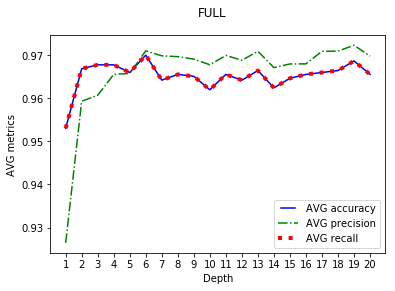

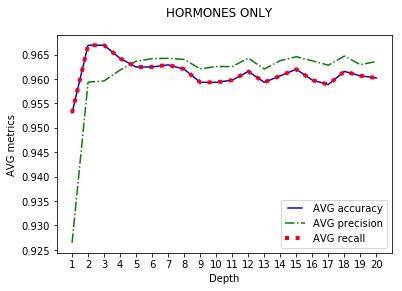

############ DF MEAN ############
Seed: 95


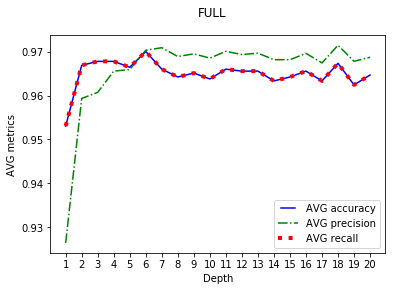

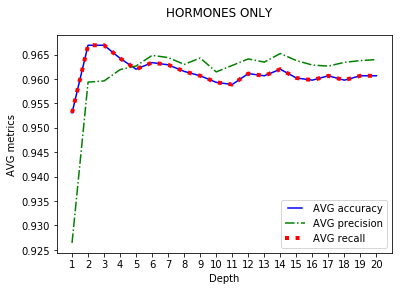

In [224]:
features_full = ["TSH","TT4","T4U","T3","pregnant_en", "psych_en", "I131 treatment_en", "goitre_en", 
                 "tumor_en", "thyroid surgery_en", "sex_en", "on thyroxine_en",
                 "query hyperthyroid_en", "query hypothyroid_en"]
features_hormones = ["TSH","TT4","T4U","T3"]

seed=random.randint(0,100)
print("############ DF MEDIAN ############\nSeed:",seed)
tree_model(df_med.copy(),features_full,"FULL",seed)
tree_model(df_med.copy(),features_hormones, "HORMONES ONLY",seed)

print("############ DF MEAN ############\nSeed:",seed)
tree_model(df_mean.copy(),features_full,"FULL",seed)
tree_model(df_mean.copy(),features_hormones, "HORMONES ONLY",seed)

As it could be easily seen by running functions above for a couple of times, an optimal depth for our tree model with both feature sets lies between 4 and 6 with rare outliers above 7.
So, we consider the value of **4** the optimal max_depth for Decision Tree model.

Also, we measured both manual and Decision Tree models on two datasets with missing numeric values filled using diferent strategies: **median** and **mean**.

As we might see from the plots above, dataset, filled by **median** values mostly has slightly better performance with "full" features and, to the lesser extent, with "hormones only" features. A dataset, filled with **mean** values sometimes gets better accuracy/precision metrics, but those cases are more rare than in **median**-filled. 

So, as a way to fill missing values in test dataset, we choose **median** with **full number of features*.

In [269]:
prediction_model=DecisionTreeClassifier(criterion="entropy", max_depth=4)
df_tr=df_med.copy()
train_fold_input = df_tr[features_full].values
train_fold_output = df_tr['class']
prediction_model.fit(train_fold_input, train_fold_output)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# IV. Comparison between manual model and Decision Tree model

As we have seen earlier, **manual model has significantly worse Accuracy, Precision and Recall** metrics, than Decision Tree model (even in "hormones only" feature selection). 

It happened mostly due to its strict hormone value bounds and abscence of more complex features selection. But nevertheless, manual algorithm _may_ perform better in case of tuning its parameters to latest up-to-date medical standards, defined by the country, where our patients were diagnosed.

Having all necessary information about prediction algoritms, we may proceed to prediction of class values for test dataset.

# V. Application on the test dataset

First, we need to preprocess our test dataset the same way as it was done above.

In [261]:
df_test_personal = pd.read_csv("Datasets/personal_test.csv", index_col=0)
df_test_other = pd.read_csv("Datasets/other_test.csv", index_col=0)

df_merged_test = pd.merge(df_test_personal, df_test_other, on=["name", "address"], how = "inner", sort = True, copy = True)

mask = df_merged_test.duplicated(subset=["name", "address"])

duplicates = df_merged_test[mask == True]

ps.fill_from_duplicates(df=df_merged_test, duplicates=duplicates, indexes=duplicates.index)

#Formatting the date
df_merged_test["date_of_birth"] = df_merged_test["date_of_birth"].apply(lambda x: ps.format_date(date=x))

#Parsing JSON medical info
df_merged_test = ps.add_columns(data=df_merged_test, json_col = "medical_info")

#Normalizing categorical columns
ps.normalize_columns_booleans(data = df_merged_test, df_new= df_merged_test)

df_merged_test["class"]="negative"


Filled_cols = ["TT4", "T4U", "TSH", "T3"]

#Iterating over columns and filling it 
for column in Filled_cols:
    ps.fill_numeric_miss_values(data=df_merged_test, column = column, method= "med")


Labeled_colums = ["pregnant", "psych", "I131 treatment", "goitre", 
                 "tumor", "thyroid surgery", "sex", "on thyroxine",
                 "query hyperthyroid", "query hypothyroid"]

a=pd.DataFrame()

#Label encoding for all columns
for col in Labeled_colums:
    lbl_encoder = LabelEncoder()    
    
    df_merged_test[col] = df_merged_test[col].apply(lambda x: str(x))    
    df_merged_test[col + "_en"] = lbl_encoder.fit_transform(df_merged_test[col])
    a[col+"_en"] = lbl_encoder.fit_transform(df_merged_test[col])
    
    print(col + " encoded!")

Labeled_colums = ["pregnant", "psych", "I131 treatment", "goitre", 
                 "tumor", "thyroid surgery", "sex", "on thyroxine",
                 "query hyperthyroid", "query hypothyroid"]

for col in Labeled_colums:
    ohe = OneHotEncoder()
    
    Xcol = ohe.fit_transform(df_merged_test[col].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(Xcol, columns = [str(col)+str(int(i)) for i in range(Xcol.shape[1])])
    pd.concat([df_merged_test, dfOneHot], axis=1)



KeyError: 97

In [262]:
df_target=df_merged_test.copy()

df_target.head()

,name,address,age,sex,date_of_birth,query hyperthyroid,FTI measured,education,lithium,TT4,...,pregnant_en,psych_en,I131 treatment_en,goitre_en,tumor_en,thyroid surgery_en,sex_en,on thyroxine_en,query hyperthyroid_en,query hypothyroid_en
0,Abigail Martinez,"32123 Thomas Ridges Suite 481\nBakerport, AZ 6...",57,F,1960-12-06,f,f,HS-grad,f,107.758929,...,0,0,0,0,0,0,1,0,0,0
1,Ada Wells,"1365 Justin Lodge Apt. 633\nEast Justin, UT 86071",60,F,1958-02-26,f,t,Bachelors,f,61.000000,...,0,0,0,0,0,0,1,0,0,0
2,Adam Wolfgram,"807 Reynolds Field\nNew Andrewview, ME 24234",38,M,1980-07-09,f,t,HS-grad,f,78.000000,...,0,0,0,0,0,0,2,2,0,0
3,Addie Taggart,Unit 4047 Box 8385\nDPO AP 46076,24,F,1993-12-13,f,t,HS-grad,f,121.000000,...,0,0,0,0,0,0,1,0,0,0
4,Adrian Carvalho,"0400 Kiara Pines Suite 134\nWatsonmouth, NH 16990",47,M,1971-07-15,f,t,Masters,f,61.000000,...,0,0,0,0,0,0,2,0,0,0


In [272]:
#Here we apply our decision tree model
prdtree=prediction_model.predict(df_target[features_full])

In [274]:
df_target['class']=prdtree

In [278]:
df_target[['name','class']].head(100)

,name,class
0,Abigail Martinez,negative
1,Ada Wells,negative
2,Adam Wolfgram,negative
3,Addie Taggart,negative
4,Adrian Carvalho,negative
5,Agustina Demar,negative
6,Albert Belanger,negative
7,Albert Saunders,negative
8,Alfredo Abels,negative
9,Alfredo Abels,negative


# Conclusion

During the final phase we created a pipeline to clean raw data for future datasets by using our own functions, stored in separate script file and in this IPYNB. As it was further found by tests on training data, a slightly better average predictions were made upon the dataset, numeric values of which were filled by **median** of all values in respectie columns. 

After that, we defined the rules for manual classification prediction model, using medical literature for getting the correct hormone values for healthy patients. Unfortunately, the accuracy, prediction and recall metrics for this method had rather bad values comparing to implemented Decision Tree model. As we described earlier, such result was obtained due to strict value borders for hormones and due to abscence of other possibly useful (_possibly_ is the keyword here) parameters, implementations of which would be too complex for manual model to handle and change in future, if medical standards would be altered in a couple of years.

So we created and trained the Decision Tree model with **"entropy"** as the main criteria and **tree depth of 4**, which was found by series of iterative experiments on training datasets. This model proved itself to be slightly more flexible and providing more accurate predictions. Comparing to manual model, its accuracy metric is approximately 10% higher, with precision and recall being even better.

Finally, in order to make predictions on real data, we merged all our preparation functions into one sequence and after that added our previously trained tree classifier to predict possible diagnosis. 

Please, note, that rows in resulting dataset are always sorted alphabetically.